## Problem 2

**Preprocessing**
The inital load of the data had some nan values, which were replaced by the median of the column.

### Part a

In [1]:
from ubiquitous_computing_machine.Problem2.part_2a import *
from ubiquitous_computing_machine.utils import get_data2
from tabulate import tabulate

X,y = get_data2()

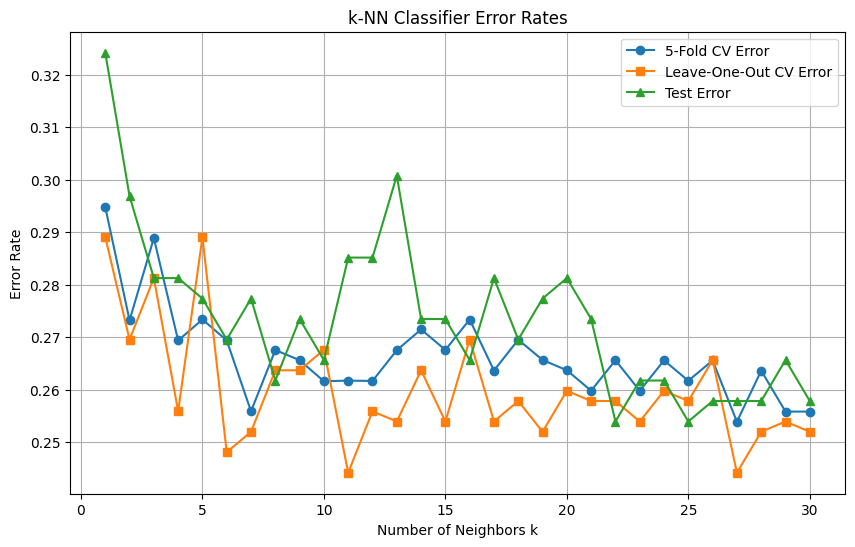

In [2]:
k_values = range(1, 31)
cv5_errors, loocv_errors, test_errors, time_usage_cv5,time_usage_loocv= evaluate_knn(X, y, k_values)
plot_errors(k_values, cv5_errors, loocv_errors, test_errors)


The figure shows a plot of Erro rate across the range `(1,31)`k values for LOOCV, 5-FoldCV and regular KNN classifier. From figure inspection we see that LOOCV performs better in terms for Error rate, while 5-fold comes second best and regular KNN comes last. 

In [3]:

average_cv5_error = sum(cv5_errors) / len(cv5_errors)
average_loocv_error = sum(loocv_errors) / len(loocv_errors)
average_test_error = sum(test_errors) / len(test_errors)

min_cv5_error = min(cv5_errors)
min_loocv_error = min(loocv_errors)
min_test_error = min(test_errors)

k_min_cv5 = k_values[cv5_errors.index(min_cv5_error)]
k_min_loocv = k_values[loocv_errors.index(min_loocv_error)]
k_min_test = k_values[test_errors.index(min_test_error)]

total_time_cv5 = sum(time_usage_cv5)
total_time_loocv = sum(time_usage_loocv)

partial_sum_loocv = sum(time_usage_loocv[:k_min_cv5])

print(f"Partial sum for LOOCV upto {k_min_loocv} NN: {partial_sum_loocv:.2f} seconds")

print(f"Total time for 5-Fold CV: {total_time_cv5:.2f} seconds")
print(f"Total time for LOOCV: {total_time_loocv:.2f} seconds")

table = [
    ["Metric", "Value", "k"],
    ["5-Fold CV min Error", min_cv5_error, k_min_cv5],
    ["LOOCV min Error", min_loocv_error, k_min_loocv],
    ["Test min Error", min_test_error, k_min_test],
    ["5-Fold CV average Error", f"{average_cv5_error:.4f}", "-"],
    ["LOOCV average Error", f"{average_loocv_error:.4f}", "-"],
    ["Test average Error", f"{average_test_error:.4f}", "-"]
]

sorted_table = [table[0]] + sorted(table[1:], key=lambda x: float(x[1]))

print(tabulate(sorted_table, headers="firstrow", tablefmt="grid"))


Partial sum for LOOCV upto 11 NN: 59.23 seconds
Total time for 5-Fold CV: 1.18 seconds
Total time for LOOCV: 65.78 seconds
+-------------------------+----------+-----+
| Metric                  |    Value | k   |
+=========================+==========+=====+
| LOOCV min Error         | 0.244141 | 11  |
+-------------------------+----------+-----+
| 5-Fold CV min Error     | 0.253855 | 27  |
+-------------------------+----------+-----+
| Test min Error          | 0.253906 | 22  |
+-------------------------+----------+-----+
| LOOCV average Error     | 0.26     | -   |
+-------------------------+----------+-----+
| 5-Fold CV average Error | 0.2664   | -   |
+-------------------------+----------+-----+
| Test average Error      | 0.2734   | -   |
+-------------------------+----------+-----+


The table above contains the sorted minimum error values for each of the three methods along with their corresponding `k` values. Additionally, it includes the sorted average error rates for each of the three methods. The table shows that LOOCV has the lowest minimum and average error rates, followed by 5-FoldCV and regular KNN.

Although LOOCV gives the best performance in terms of error rate, it is computationally expensive for upto the `k` value giving the minimim error rate for the LOOCV method It has taken 55 seconds while for 5-FoldCV for the whole range of `k` values it has taken 1 second.
The reason for this is that LOOCV has to train the model `n` times, where `n` is the number of samples in the dataset. The reason LOOCV performs better than 5-FoldCV is that it uses more data for training the model, which results in a better model. However, this comes at the cost of computational time.

### Part b

Fitting a generalized additive model (GAM) with splines and use a variable selection method to select the most important features. 
In this part it is used `pygam` library to fit a GAM model with splines. And then `AIC` is as the information criterion to select the most important features. 

In [4]:
from ubiquitous_computing_machine.Problem2.part_2b import *

**Single regular GAM fit**

In [5]:
n_splines = 5
spline_order = 3
n_features = X.shape[1]
gam_splines = create_gam_splines(n_features,spline_order,n_splines )
gam_p, e_rate = fit_gam_model(X,y,gam_splines)
print(f"Estimated error rate: {e_rate:.4f}")

Estimated error rate: 0.2539


When doing a single regular GAM fit with spline type being cubic, and number of splines being 5 for each feature, we get an error rate of `0.2538` which is on par with the minimum error rate of the 5-FoldCV and error rate of the regular KNN classifier.  

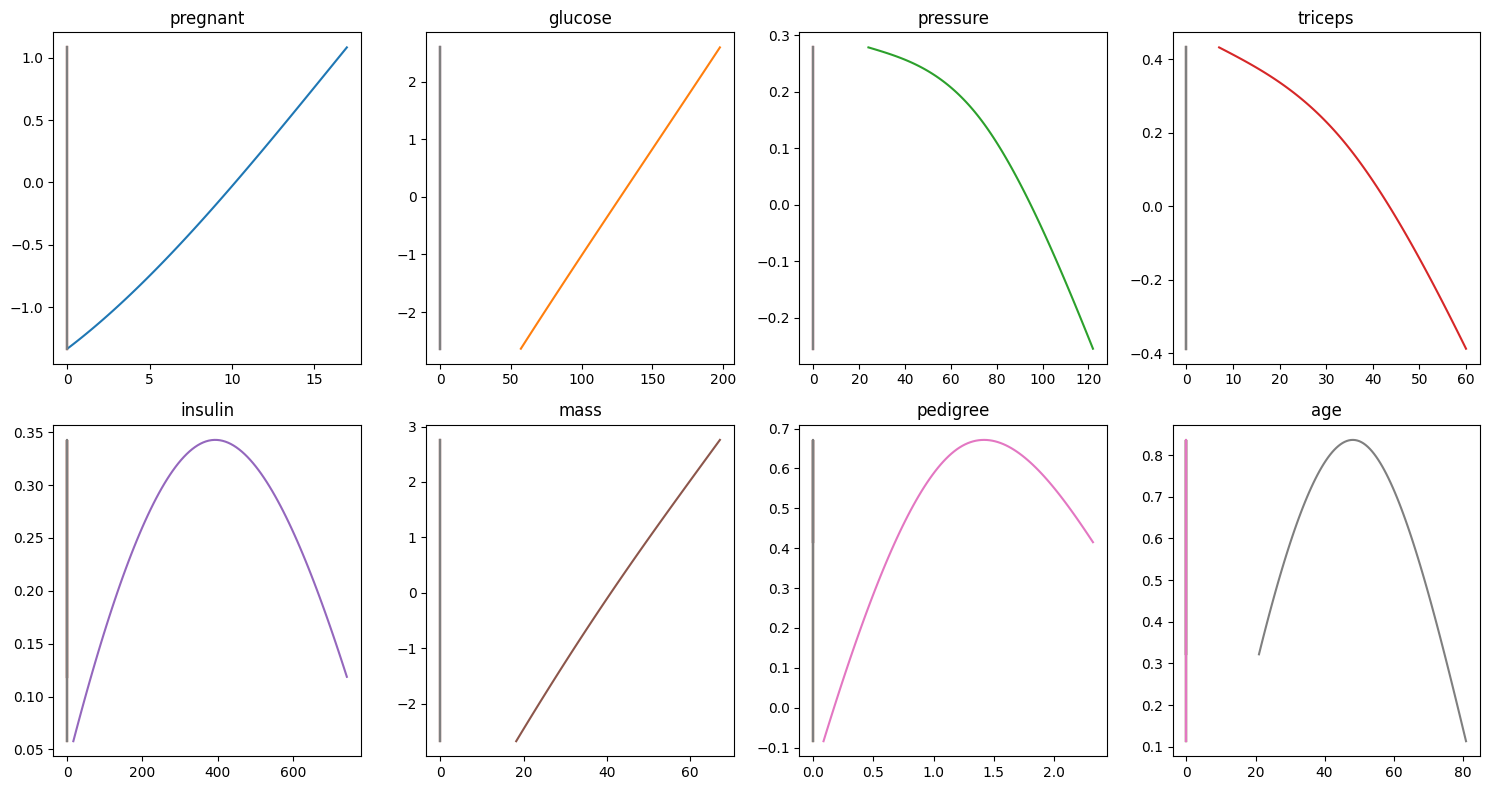

In [6]:
plot_p_dep_LGAM(gam_p)

Figure above shows the Logsitic part dependence plot for the GAM model. The plot shows the effect of each feature on the response variable. The plot shows that the feature `pregnant`
`glucode`and `mass` positive linear relationship with the response variable, while the rest are non linear. 

In [7]:
best_gam, best_feat, best_aic, best_e_rate = perform_variable_selection_logistic(X,y,spline_order,n_splines)

print(f"Best feature: {best_feat}")
print(f"Best Error_rate: {best_e_rate:.4f}")


Best feature: ('pregnant', 'glucose', 'mass', 'pedigree', 'age')
Best Error_rate: 0.2617


After performing feature selection using AIC, we found that the following features are the most important: `pregnant`, `glucose`, `mass`, `pedigree`, and `age`. The error rate of the model with the selected features is `0.2617`, which is slightly higher than the error rate of the model with all features. This indicates that the model with all features is better than the model with the selected features. However ommiting two features does not have a significant impact on the error rate. So for performance reasons, it is better to use the model with the selected features.

### Part c
Fit (i) a classification tree, (ii) an ensemble of bagged trees and (iii) a
random forest to the data. Report the training and the test error for
each method and comment on results.

In [8]:
from ubiquitous_computing_machine.Problem2.part_2c import *

In [9]:
max_depths = range(3, 15)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)
find_best_depth(x_train, y_train, x_test, y_test, max_depths)

                 Model  Best Depth  Best Error
0  Classification Tree           7    0.253906
1        Random Forest          10    0.226562
2              Bagging           3    0.238281


In this part we define three models: a classification tree, an ensemble of bagged trees, and a random forest. we then fit each model with a range of maximum being `range(3,15)` and test error for each model. Then it is the best error rate is taken in the max depth range for each model.

The above table contains the results with random forest having the lowest error rate of `0.226526` with max depth of `10`. 

This is significantly better then all thre previous models from earlier parts. 


### Part d

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [11]:
NN = MLPClassifier(
    max_iter=800,
    activation="logistic",
    random_state=42,
    hidden_layer_sizes=(500,),
    learning_rate="adaptive",

)

param_grid = {
    "alpha": np.logspace(-0.5,0.5, 100),
}

grid_search = GridSearchCV(NN, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(x_train, y_train)


print("Best parameters: ", grid_search.best_params_)

print(f"Neural network test error rate: {1 - grid_search.score(x_test, y_test)}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters:  {'alpha': 1.035503366489131}
Neural network test error rate: 0.2421875


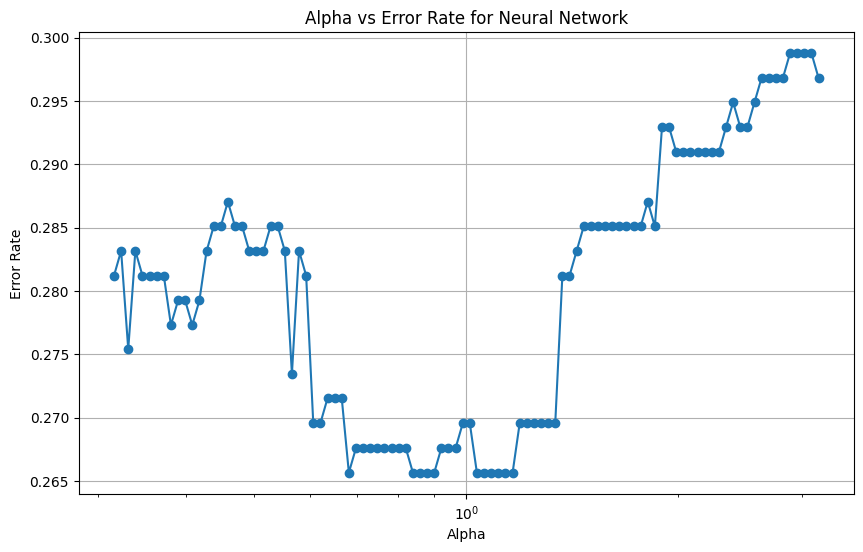

In [12]:
import matplotlib.pyplot as plt
alphas = grid_search.cv_results_['param_alpha'].data
mean_test_scores = grid_search.cv_results_['mean_test_score']

plt.figure(figsize=(10, 6))
plt.plot(alphas, 1 - mean_test_scores, marker='o') 
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Error Rate')
plt.title('Alpha vs Error Rate for Neural Network')
plt.grid(True)
plt.show()


For this part Fitting a NN to the data I have been been setting an initial parameter list: 

| Parameter            | Value       |
|----------------------|-------------|
| max_iter             | 800         |
| activation           | logistic    |
| random_state         | 42          |
| hidden_layer_sizes   | (500,)      |
| learning_rate        | adaptive    |
| k-fold               | 5           |

Other parameters not listed here are use default values.



Then I have been tuning the `alpha` parameter for the model using GridSearchCV. The result from the search are as follows:

| Metric                        | Value             |
|-------------------------------|-------------------|
| Best alpha                    | 1.035503366489131 |
| NN test error rate            | 0.2421875         |


NN have many parameters that can be used to tune however the realationship between the parameters and the error rate is not very clear and it is computationally expensive to tune all the parameters.



In [13]:
NN = MLPClassifier(
    max_iter=800,
    activation="logistic",
    random_state=42,
    # hidden_layer_sizes=(500,),
    learning_rate="adaptive",

)

param_grid = {
    "alpha": np.logspace(-0.5,0.5, 30),
    "hidden_layer_sizes": [(500,), (400,),(300,)],
}

grid_search = GridSearchCV(NN, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(x_train, y_train)


print("Best parameters: ", grid_search.best_params_)

print(f"Neural network test error rate: {1 - grid_search.score(x_test, y_test)}")

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters:  {'alpha': 2.697953640073, 'hidden_layer_sizes': (400,)}
Neural network test error rate: 0.234375


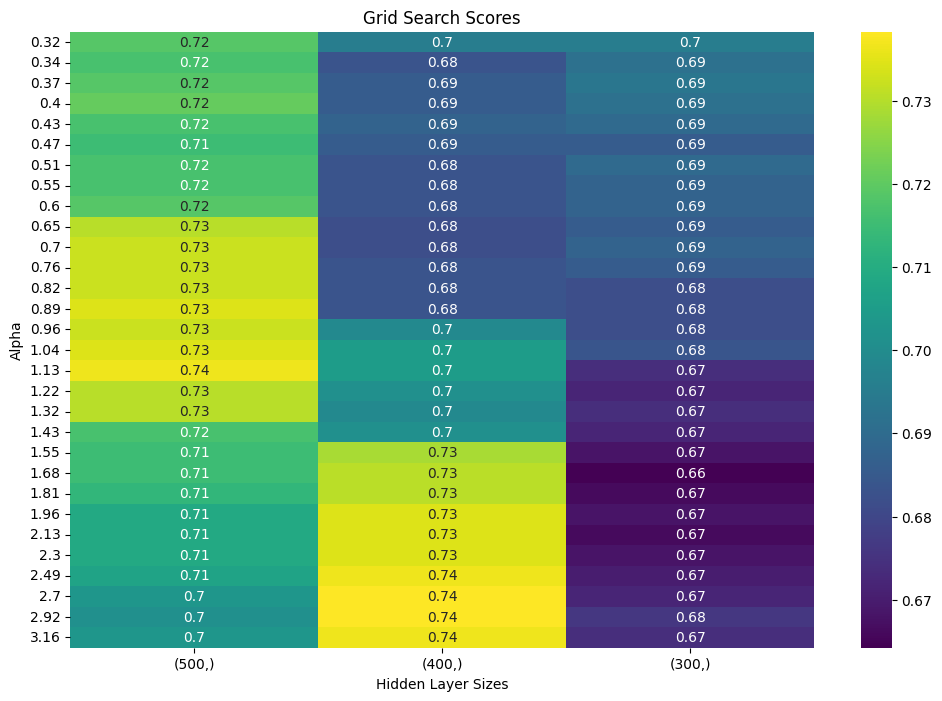

In [14]:
import seaborn as sns

alphas = grid_search.cv_results_['param_alpha'].data
mean_test_scores = grid_search.cv_results_['mean_test_score']

results = grid_search.cv_results_
scores_matrix = results['mean_test_score'].reshape(len(param_grid['alpha']), len(param_grid['hidden_layer_sizes']))

plt.figure(figsize=(12, 8))
sns.heatmap(scores_matrix, xticklabels=param_grid['hidden_layer_sizes'], yticklabels=np.round(param_grid['alpha'], 2), annot=True, cmap="viridis")
plt.xlabel('Hidden Layer Sizes')
plt.ylabel('Alpha')
plt.title('Grid Search Scores')
plt.show()

THe aove figures shows a heatmap for grid search for two parameters being `alpha` and `hidden_layer_sizes` 

The table below shows the parameter grid used for the grid search:

| Parameter            | Values                                      |
|----------------------|---------------------------------------------|
| alpha                | np.logspace(-0.5, 0.5, 30)                  |
| hidden_layer_sizes   | [(500,), (400,), (300,)]                    |


The table below shows the result of the grid search:

| Metric                        | Value             |
|-------------------------------|-------------------|
| Best alpha                    | 2.697953640073    |
| Best hidden layer sizes       | (400,)            |
| Neural network test error rate| 0.234375          |

In here we have found a best fit for the NN model giving an error rate of `0.234375` is better then whattwe found earlier with only tuning the `alpha` parameter.

### Part e


| Model                         | Error Rate | Parameters                    |
|-------------------------------|------------|-------------------------------|
| Random Forest                 | 0.226526   | max_depth=10                  |
| Neural Network                | 0.234375   | alpha=2.698, hidden_layer_sizes=(400,) |
| KNN (LOOCV)                   | 0.244141   | k=11                          |
| KNN (Test)                    | 0.253906   | k=22                          |
| KNN (5-Fold CV)               | 0.253855   | k=27                          |
| GAM (Full model)              | 0.253900   | -                             |
| GAM (Selected features model) | 0.261700   | -                             |

Among all methods tested, I would recommend using the Random Forest classifier for this diabetes prediction task because:

It achieved the lowest error rate (0.226526) among all methods tested
Random Forests are generally robust against overfitting due to their ensemble nature
They provide good interpretability through feature importance measures
They handle both numerical and categorical variables well
They require relatively less parameter tuning compared to neural networks
They can capture non-linear relationships without explicit feature engineering

While the Neural Network also performed well (0.234 error rate), it required more extensive parameter tuning and is less interpretable. The simpler methods like KNN and GAM, while providing decent performance, didn't match the predictive power of the ensemble methods.
